<div style="background:#FFFFAA">
<img src="./utils/LogoL2RPN.jpg", width=150, ALIGN="left", border=10>
<h1>L2RPN 2019 Starting Kit </h1> 


ALL INFORMATION, SOFTWARE, DOCUMENTATION, AND DATA ARE PROVIDED "AS-IS". The CDS, CHALEARN, AND/OR OTHER ORGANIZERS OR CODE AUTHORS DISCLAIM ANY EXPRESSED OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR ANY PARTICULAR PURPOSE, AND THE WARRANTY OF NON-INFRIGEMENT OF ANY THIRD PARTY'S INTELLECTUAL PROPERTY RIGHTS. IN NO EVENT SHALL AUTHORS AND ORGANIZERS BE LIABLE FOR ANY SPECIAL, 
INDIRECT OR CONSEQUENTIAL DAMAGES OR ANY DAMAGES WHATSOEVER ARISING OUT OF OR IN CONNECTION WITH THE USE OR PERFORMANCE OF SOFTWARE, DOCUMENTS, MATERIALS, PUBLICATIONS, OR INFORMATION MADE AVAILABLE FOR THE CHALLENGE. 
</div>

<div style="background:#FFFFAA">
    <h2>Introduction </h2>
    <p> 
     <br>
The goal of this challenge is to use Reinforcement Learning in Power Grid management by designing RL agents to automate the control of the power grid. We are using a power network simulator : <a href="https://github.com/rte-france/Grid2Op">Grid2Op</a>, it is a simulator that is able to emulate a power grid of any size and electrical properties subject to a set of temporal injections for discretized time-steps.

References and credits: <br>
The creator of Grid2Op was Benjamin Donnot. The competition was designed by Isabelle Guyon, Antoine Marot, Benjamin Donnot and Balthazar Donon. Luca Veyrin, Camillo Romero, Marvin Lerousseau and Kimang Khun are distinguished contributors to make the L2RPN challenge happen. 
 <br> 
</div>

In [1]:
import sys
import os
import logging
import warnings
import json
from sys import path
import numpy as np
import pandas as pd

# Uncomment the next lines to auto-reload libraries (this causes some problem with pickles in Python 3)
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt

import grid2op

warnings.simplefilter(action='ignore', category=FutureWarning)

Useful paths for the submission and for data

In [2]:
this_dir = os.getcwd()
above_dir, final_dir = os.path.split(this_dir)
above_above_dir, secondfinal_dir = os.path.split(above_dir)

In [3]:
# the first step tries to determine from where the jupyter notebook was started, and adapt the path accordingly
if final_dir == "starting_kit":
    # path where "submission.py" should be
    model_dir = 'agent_path'
    
    # location of some utilities script to mimic codalab behaviour
    utility_dir = "../l2rpn2019_utils"
    utility_dir = os.path.abspath(utility_dir)
    
    # training data set
    # if you didn't we encourage you to download the training data
    path_train_set = '../data/data_l2rpn_2019'
    path_train_set = os.path.abspath(path_train_set)
    
    # path where the final results and temporary data will be located
    output_dir = 'output_notebook_2DevelopAndRunLocally'
    tmp_outdir = os.path.join(output_dir, "tmp_results")
    if not os.path.exists(output_dir):
        print("Creating path \"{}\" where the output of this notebook will be stored".format(output_dir))
        os.mkdir(output_dir)
    if not os.path.exists(tmp_outdir):
        print("Creating path \"{}\" where the temporary output will be stored".format(tmp_outdir))
        os.mkdir(tmp_outdir)
else:
    raise RuntimeError("For this notebook to work properly, you should not have modified the github clone "
                       "where you found the l2rpn_2019 utilities, starting kit and other materials")

In [5]:
path.append(model_dir)
path.append(utility_dir)

# import what depends on the above path
from create_env import main as main_l2rpn2019

<div style="background:#FFFFAA">
    <h1> Step 1: Exploratory data analysis </h1>
</div>

## Electrical grid
<div >
<img src="utils/IEEE14Example.png", width=750, ALIGN="left", border=20>
    <br>
    <br>
(courtesy of Marvin Lerousseau)
</div>

During the challenge, a grid of 14 substations is given. 20 lines are connected through the nodes of the grids within substations.

explore others notebooks for better understanding of the power network behavior: 
 - Power_Grid_101_notebook.ipynb
 - visualize_14grid_with_customized_actions.ipynb [copming soon]

In our grid environment, we take the case where there are 11 loads and 5 prods. Furthermore, we will only consider chronics over the month of January, the only month for which contestants are tested. Let's have a look at some of the chronics.

In [6]:
env = grid2op.make("l2rpn_2019", chronics_path=path_train_set)

**NB** The first time you run this notebook, you will have to download the data of the 2019 competition. To do that you can use the script [download_training_data.py](l2rpn2019_utils/download_training_data.py) and run:

```python l2rpn2019_utils/download_training_data.py```

and when the download is terminated you will have the whole training data at your disposal.

## Loads

The following figure shows the active power of consumptions which represents the amount of demand of active power. You can notice the daily seasonality as well as the weekdays and weekend difference in consuming behavior. In our particular case, the load 3_C151.15 at substation 3 is the one which has the highest demand. The loads for the other levels are pretty similar with a load needing much more power than the others.

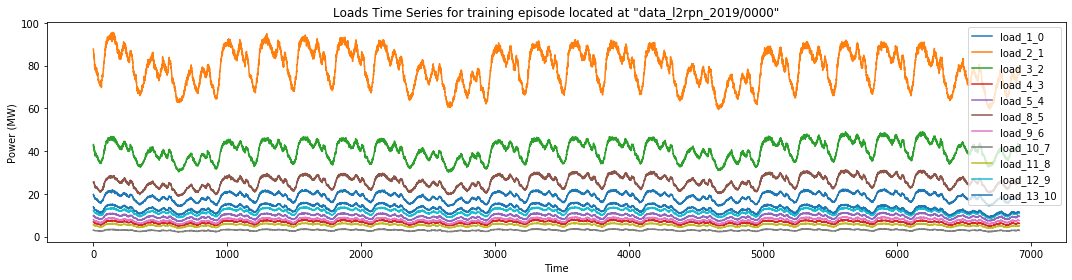

In [7]:
proper_folder_name = env.chronics_handler.get_id()
proper_folder_name, last = os.path.split(proper_folder_name)
proper_folder_name, secondlast = os.path.split(proper_folder_name)
pretty_chronics_name = os.path.join(secondlast, last)

plt.figure(figsize=[15,4])
plt.title('Loads Time Series for training episode located at "{}"'.format(pretty_chronics_name))
plt.xlabel('Time')
plt.ylabel('Power (MW)')
for load_id, load_name in enumerate(env.name_load):
    plt.plot(env.chronics_handler.real_data.data.load_p[:,load_id], label="{}".format(load_name))
plt.legend()
plt.tight_layout()
plt.show()

## Production

The active power of the productions is shown below. We have a quite stable nuclear production as well as renewable energies, wind and solar, with a high variance. FInally a thermal power plant matches the residual demand.

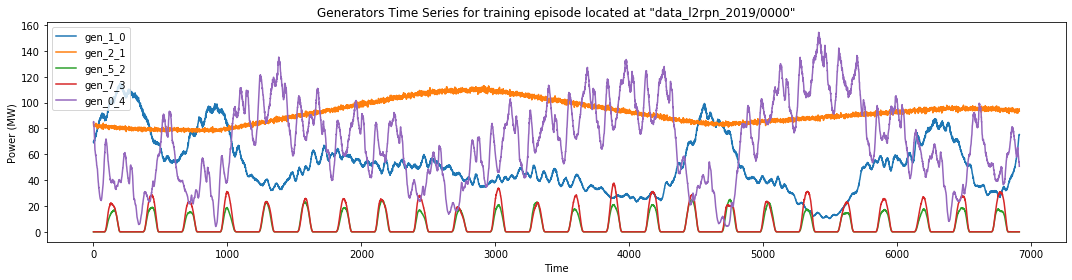

In [8]:
plt.figure(figsize=[15,4])
plt.title('Generators Time Series for training episode located at "{}"'.format(os.path.join(secondlast, last)))
plt.xlabel('Time')
plt.ylabel('Power (MW)')
for gen_id, gen_name in enumerate(env.name_gen):
    plt.plot(env.chronics_handler.real_data.data.prod_p[:,gen_id], label="{}".format(gen_name))
plt.legend()
plt.tight_layout()
plt.show()

## Maintenance & Hazards

Grid2op handles mintenance and hazards in the scenarios. But in this competition there is no hazard and maintenance operations. However overloads can still occur and have to be managed.

<div style="background:#FFFFAA">
<h1>Step 2: Building an Agent</h1>
</div>

<div style="background:#FFFFAA">
    <h2>Building an agent</h2>
    <p>
We provide simple examples of agent in the `starting-kit/example_submission` directory. We illustrate it here with the most simple agent: the lazy "do nothing". To make your own agent, you can change the agent init to load your own model, you can modify the act method to take action with your model and specify a reward, especially if you are doing reinforcement learning.
    </div>

## Do nothing agent

The agent does not take any actions.

In [9]:
from grid2op.Agent import Agent

class DoNothingAgent(Agent):
    """ The template to be used to create an agent: any controller of the power grid is expected to be a daughter of this
    class.
    """

    def __init__(self, action_space):
        """Initialize a new agent."""
        DoNothingAgent.__init__(self, action_space=action_space)

    def act(self, observation):
        return self.action_space({})

    def feed_reward(self, action, consequent_observation, rewards_aslist):
        pass

To make a submission on the challenge, you should name your agent Submission and write in submission.py file.

Here is an example with the doNothing agent: we changed the name of the agent as Submission and can write it in a .py file by uncommenting the %%writefile

In [10]:
#%%writefile example_submission/submission.py
class Submission(DoNothingAgent):
    """ The template to be used to create an agent: any controller of the power grid is expected to be a daughter of this
    class.
    """
    def __init__(self, action_space):
        """Initialize a new agent."""
        DoNothingAgent.__init__(self, action_space=action_space)

    def act(self, observation):
        return self.action_space({})

    def feed_reward(self, action, consequent_observation, rewards_aslist):
        pass
#if you want to load a file (in this directory) names "model.dump"
#open("program/model.dump")

## Other baselines

Uncomment one of the lines below to see the code of the agent : (keep the ??)

In [11]:
# do not change the two lines bellow, this is technical importation to make your agent run locally and not 
# only on the codalab platform
from ingestion import names_chronics_to_backend, ReadPypowNetData, L2RPNReward
from grid2op.main import main

#or you can try your own submission
import submission #existing exemple as submission.py
agent_class = submission.Submission

# other basline agent can be found at 
# below is a replica of the script used to assess the performance of your agent on the correct dataset.
# no need to modify it.
res = main_l2rpn2019(nb_episode=1, max_timestep=100, submission_dir=model_dir, path_chronics=path_train_set)
for chron_name, cum_reward, nb_time_step, max_ts in res:
    proper_folder_name, last = os.path.split(chron_name)
    proper_folder_name, secondlast = os.path.split(proper_folder_name)
    pretty_chronics_name = os.path.join(secondlast, last)
    msg_tmp = "\tFor chronics located at \"{}\"\n".format(pretty_chronics_name)
    msg_tmp += "\t\t - cumulative reward: {:.2f}\n".format(cum_reward)
    msg_tmp += "\t\t - number of time steps completed: {:.0f} / {:.0f}\n".format(nb_time_step, max_ts)
    print(msg_tmp)

	For chronics located at "data_l2rpn_2019/0000"
		 - cumulative reward: 1542.13
		 - number of time steps completed: 100 / 100



## The Reward and the Score of an agent
At each step grid2op return a reward to the agent.

This reward is used to compute the Score for ranking participants in this current challenge.
the final Score is the sum of the score of each scenario. for a scenario there is two option :
 - Your agent got a game over, the Score for this scenario is 0
 - your agent got no game over, the Score of this scenario is the sum of the reward at each timestep of this scenario
 
### Computation of the reward
For each timestep grid2op returns a reward : the normalised sum of the margin for each line <br>
<p>
    \[
        R= \sum_{l\in lines} \max\left(\frac{i_{l_{max}}-i_l}{i},0\right)
    \]
</p>
With $i_l$ the flow on the line l and $i_{l_{max}}$ the maximum allowed flow on this line.<br>
The final score on one chronic is the sum of the rewards over the each timestep

for better understanding of the reward calulation please look at <code>public_data/reward_function.py</code> for training purposes you can modify this function. 


### Run an agent 

Once you have defined an agent, you can run it under an environment over scenarios.

**WARNING**: the following cell to compute the leaderboard score will not run if you did not use the "augmented" runner previously.

<div style="background:#FFFFAA">
<h1> Step 3: Making a submission </h1> 

<h2> Unit testing </h2> 

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. All you have to do to make a submission is create or modify the <code>Sumbission</code> class the file <code>submission.py</code>  in the <code>starting_kit/example_submission/</code> directory, then run this test to make sure everything works fine. This is the actual program that will be run on the server to test your submission. <br>

take note that on codalab, your local directory is <code>program/</code>. Then if you want to load the file <code>model.dump</code> run : <code>open("program/model.dump")</code> even if the file is in at the root of your submission dir.
</div>

In [12]:
print("The following cell will execute the command: \n"
      "{} {} {} {} {} {}".format(sys.executable, os.path.join(utility_dir, "ingestion.py"),
                                path_train_set, tmp_outdir, utility_dir, model_dir))

The following cell will execute the command: 
/usr/bin/python3.6 /home/benjamin/Documents/grid2op_dev/l2rpn_2019/l2rpn2019_utils/ingestion.py /home/benjamin/Documents/grid2op_dev/l2rpn_2019/data/data_l2rpn_2019 output_notebook_2DevelopAndRunLocally/tmp_results /home/benjamin/Documents/grid2op_dev/l2rpn_2019/l2rpn2019_utils agent_path


In [13]:
!$sys.executable $utility_dir/ingestion.py $path_train_set $tmp_outdir $utility_dir $model_dir

Done and data saved in : "/home/benjamin/Documents/grid2op_dev/l2rpn_2019/starting_kit/output_notebook_2DevelopAndRunLocally/tmp_results/saved_experiment"


<div style="background:#FFFFAA">
    The above command will run a file close really close to what codalab is running to assess the performance of the agent. The data (that you will not have access to for the real validation dataset) will be located in a subdirectory of "output_notebook_2DevelopAndRunLocally/tmp_results".
    <br>
    <br>
    As the data that are used in the codalab platform to compute your code are hidden, here we simulate the evaluation with 2 scenarios coming from the training data, for which we limit the number of time step at 100 each. The real length of validation scenarios is variable and not disclosed here.
    <br>
    <br>
     It is more than recommended to also test the scoring program with the following script.
</div>

In [14]:
!$sys.executable $utility_dir/evaluate.py $tmp_outdir $output_dir
# print("watch : http:/view/"+ scoring_output_dir +"/scores.html")

input_dir: output_notebook_2DevelopAndRunLocally/tmp_results
output_dir: output_notebook_2DevelopAndRunLocally
Score for scenario 0001: 1595.0512709067282
Score for scenario 0000: 1542.1342069852371
Your submission is valid, you may proceed with the next steps


<div style="background:#FFFFAA">
    <h1> Preparing the submission </h1>

Zip the contents of `sample_code_submission/` (without the directory), or download the challenge public_data and run the command in the previous cell, after replacing sample_data by public_data.
Then zip the contents of `sample_result_submission/` (without the directory).
<b><span style="color:red">Do NOT zip the data with your submissions</span></b>.

In [ ]:
import datetime 
import zipfile

def zipdir(path, ziph):
    # ziph is zipfile handle
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file))

the_date = datetime.datetime.now().strftime("%y%m%d_%H%M")
sample_code_submission = 'sample_code_submission_' + the_date + '.zip' 

with zipfile.ZipFile(sample_code_submission, 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipdir(model_dir,zipf)
print("Submit this file:\n\t- {}\n\t- Located at{}".format(sample_code_submission, os.path.abspath(".")))